**Imports**

In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import saraRC1 as sara

import os
import sys

import deepgaze_pytorch

DEVICE = 'cuda'

In [2]:
IMG_DIR = '../ablation/images'
MASK_DIR = '../ablation/masks'

In [3]:
images = sorted([f for f in os.listdir(IMG_DIR) if f.endswith('.jpg')])
masks = sorted([f for f in os.listdir(MASK_DIR) if f.endswith('.png')])
names = []

with open(IMG_DIR + '/names.txt', 'r') as f:
    names = f.readlines()
    names = [x.strip() for x in names]

imgs = []
msks = []

for img in images:
    imgs.append(cv2.cvtColor(cv2.imread(os.path.join(IMG_DIR, img)), cv2.COLOR_BGR2RGB))

    mask = cv2.imread(os.path.join(MASK_DIR, img.replace('.jpg', '.png')))
    msks.append(mask)

segments = {}

for img, mask, name in zip(imgs, msks, names):
    segments[name] = {}
    segments[name]['segments'] = []
    segments[name]['coordinates'] = []

    bg = [255, 255, 255]


    # Detect number of unique colors in the mask
    colors = np.unique(mask.reshape(-1, mask.shape[2]), axis=0)
    colors = [np.array(c) for c in colors]

    for i, color in enumerate(colors):
        if color[0] == 0 and color[1] == 0 and color[2] == 0:
            continue

        # Create a mask for the current color
        mask_color = cv2.inRange(mask, color, color)
        mask_color = cv2.cvtColor(mask_color, cv2.COLOR_GRAY2BGR)

        # Apply the mask to the image
        masked = cv2.bitwise_and(img, mask_color)

        # Find the bounding box of the mask
        gray = cv2.cvtColor(mask_color, cv2.COLOR_BGR2GRAY)
        _, thresh = cv2.threshold(gray, 1, 255, cv2.THRESH_BINARY)
        contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        x, y, w, h = cv2.boundingRect(contours[0])

        # Coordinates tuple which is top left, bottom right
        coord_tup = (i, x, y, x+w, y+h)

        # Crop the image to the bounding box
        cropped = masked[y:y+h, x:x+w]

        # Regions within the bounding box but not covered by the mask should be made white
        cropped[mask_color[y:y+h, x:x+w] == 0] = 255
        
        # Append the cropped image to the list of segments
        segments[name]['segments'].append(cropped)

        # Append the coordinates to the list of coordinates
        segments[name]['coordinates'].append(coord_tup)


pairs = [
    (0, 2),
    (1, 3),
    (4, 6),
    (5, 7)
]

**Load Images**

In [4]:
p = 1

img_a, img_b = imgs[pairs[p][0]], imgs[pairs[p][1]]
name_a, name_b = names[pairs[p][0]], names[pairs[p][1]]
mask_a, mask_b = msks[pairs[p][0]], msks[pairs[p][1]]

In [5]:
def get_saliency_map(img, name, deepgaze_model):
    sara.reset()
    sara.WEIGHTS = (2, 1, 0, 0)
    saliency_map = sara.return_saliency(img, generator='deepgaze', deepgaze_model=deepgaze_model, DEVICE='cuda')
    [sara_heatmap, text_overlay], sara_list = sara.return_sara(img.copy(), saliency_map=saliency_map, segments=segments[name]['segments'], coords=segments[name]['coordinates'], mode=2)

    overlay = img.copy()
    overlay = cv2.cvtColor(overlay, cv2.COLOR_RGB2RGBA)
    colormap = cv2.applyColorMap(sara_heatmap, cv2.COLORMAP_JET)
    colormap = cv2.cvtColor(colormap, cv2.COLOR_BGR2RGBA)

    sara_heatmap = cv2.cvtColor(sara_heatmap, cv2.COLOR_RGB2RGBA)
    sara_heatmap[:, :, 3] = np.where((sara_heatmap[:, :, :3] == [0, 0, 0]).all(axis=2), 0, 255)

    for i in range(3):
        sara_heatmap[:, :, i] = colormap[:, :, i]

    text_overlay = cv2.cvtColor(text_overlay, cv2.COLOR_RGB2RGBA)

    text_overlay[text_overlay[:, :, 0] < 192] = [0, 0, 0, 0]
    text_overlay[text_overlay[:, :, 0] >= 192, 3] = 255
    text_overlay = cv2.GaussianBlur(text_overlay, (3, 3), 0)
    shadow = cv2.GaussianBlur(text_overlay, (21, 21), 0)

    sara_heatmap_outline = sara_heatmap.copy()
    sara_heatmap_outline = cv2.cvtColor(sara_heatmap_outline, cv2.COLOR_RGBA2RGB)
    sara_heatmap_outline = cv2.Canny(sara_heatmap_outline, 100, 200)
    sara_heatmap_outline = cv2.cvtColor(sara_heatmap_outline, cv2.COLOR_GRAY2RGBA)
    
    return saliency_map, sara_heatmap, sara_list, text_overlay, sara_heatmap_outline, shadow

In [6]:
deepgaze_model = deepgaze_pytorch.DeepGazeIIE(pretrained=True).to(DEVICE)

saliency_map_a, sara_heatmap_a, sara_list_a, text_overlay_a, sara_heatmap_outline_a, shadow_a = get_saliency_map(img_a, name_a, deepgaze_model)
saliency_map_b, sara_heatmap_b, sara_list_b, text_overlay_b, sara_heatmap_outline_b, shadow_b = get_saliency_map(img_b, name_b, deepgaze_model)

Loaded pretrained weights for efficientnet-b5


Using cache found in /home/matthewkenely/.cache/torch/hub/pytorch_vision_v0.6.0
Using cache found in /home/matthewkenely/.cache/torch/hub/pytorch_vision_v0.6.0
/home/matthewkenely/Programming/Assignments/ICT3909 Final Year Project in Artificial Intelligence/ICT3909/saliency-ranking/saraRC1.py:119: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  ../torch/csrc/utils/tensor_new.cpp:201.)
  image_tensor = torch.tensor([image.transpose(2, 0, 1)]).to(DEVICE)


[(231, 231, 231), (208, 208, 208), (185, 185, 185), (162, 162, 162), (139, 139, 139), (116, 116, 116), (93, 93, 93), (70, 70, 70), (47, 47, 47), (24, 24, 24), (1, 1, 1)]
[(231, 231, 231), (208, 208, 208), (185, 185, 185), (162, 162, 162), (139, 139, 139), (116, 116, 116), (93, 93, 93), (70, 70, 70), (47, 47, 47), (24, 24, 24), (1, 1, 1)]


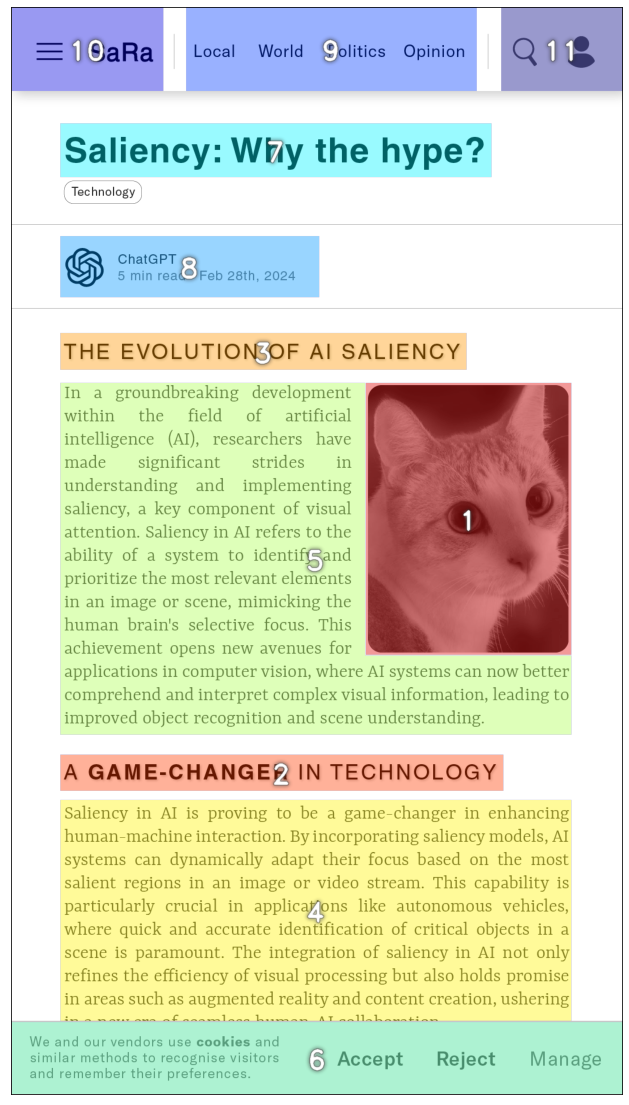

In [7]:
plt.figure(figsize=(20, 20))

plt.imshow(cv2.cvtColor(img_a, cv2.COLOR_BGR2GRAY), cmap='gray')
plt.imshow(sara_heatmap_a, alpha=0.4)
plt.imshow(shadow_a)
plt.imshow(text_overlay_a)

plt.xticks([]), plt.yticks([])

plt.show()

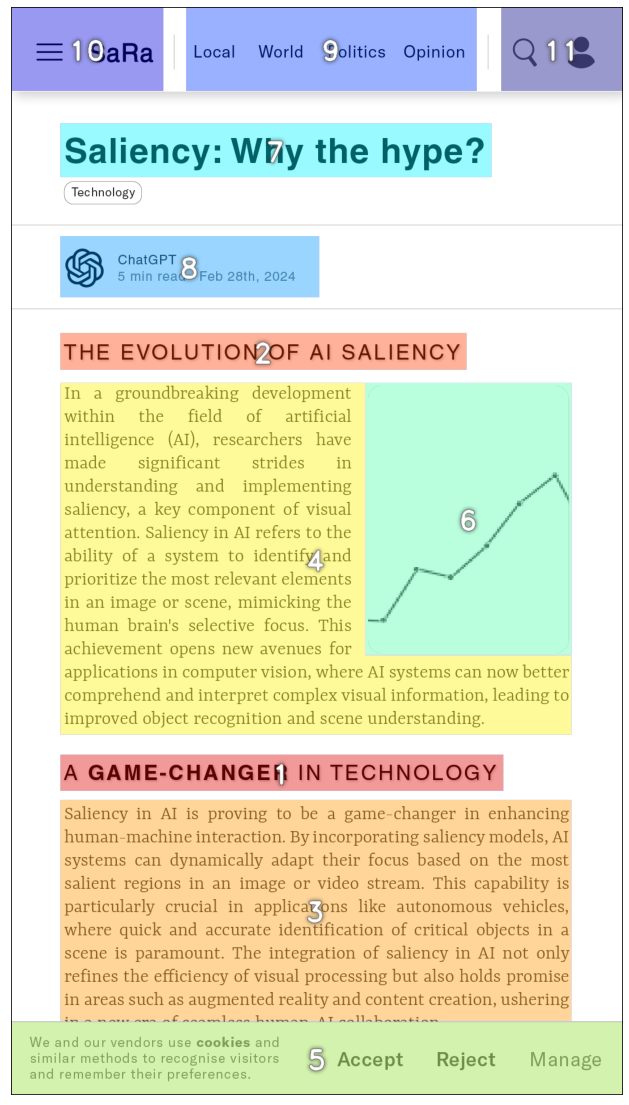

In [8]:
plt.figure(figsize=(20, 20))

plt.imshow(cv2.cvtColor(img_b, cv2.COLOR_BGR2GRAY), cmap='gray')
plt.imshow(sara_heatmap_b, alpha=0.4)
plt.imshow(shadow_b)
plt.imshow(text_overlay_b)

plt.xticks([]), plt.yticks([])



plt.show()

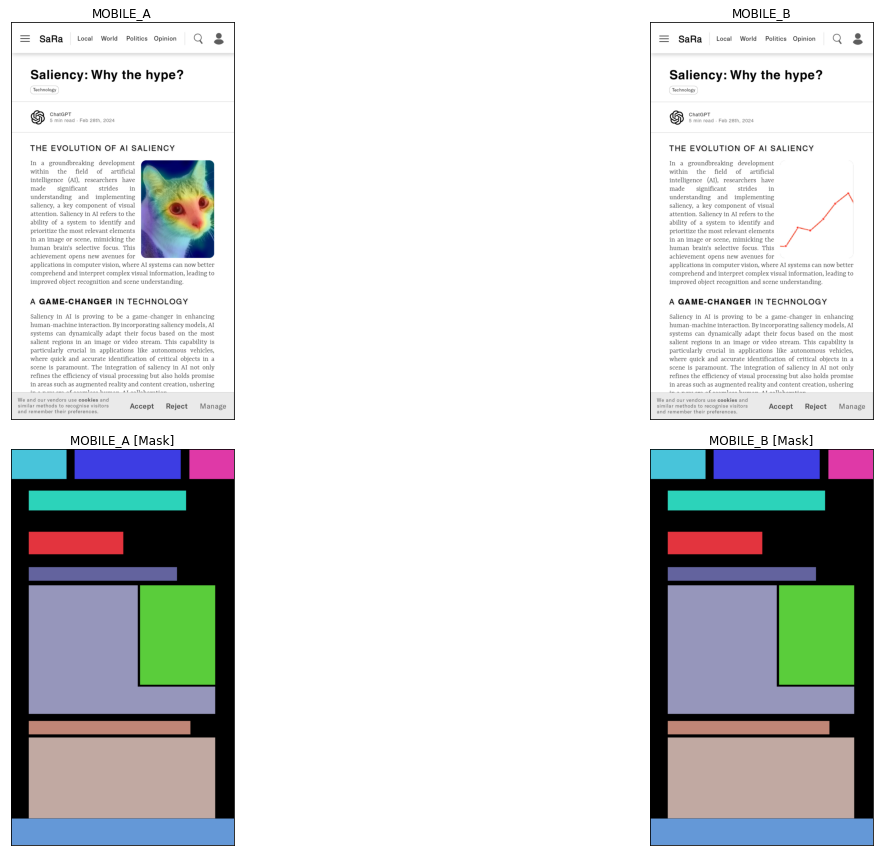

In [9]:
plt.figure(figsize=(24, 12))

plt.subplot(221)
plt.imshow(img_a)
plt.title(name_a)
plt.xticks([])
plt.yticks([])

plt.subplot(222)
plt.imshow(img_b)
plt.title(name_b)
plt.xticks([])
plt.yticks([])

plt.subplot(223)
plt.imshow(mask_a)
plt.title(name_a + ' [Mask]')
plt.xticks([])
plt.yticks([])

plt.subplot(224)
plt.imshow(mask_b)
plt.title(name_b + ' [Mask]')
plt.xticks([])
plt.yticks([])


plt.tight_layout()
plt.show()

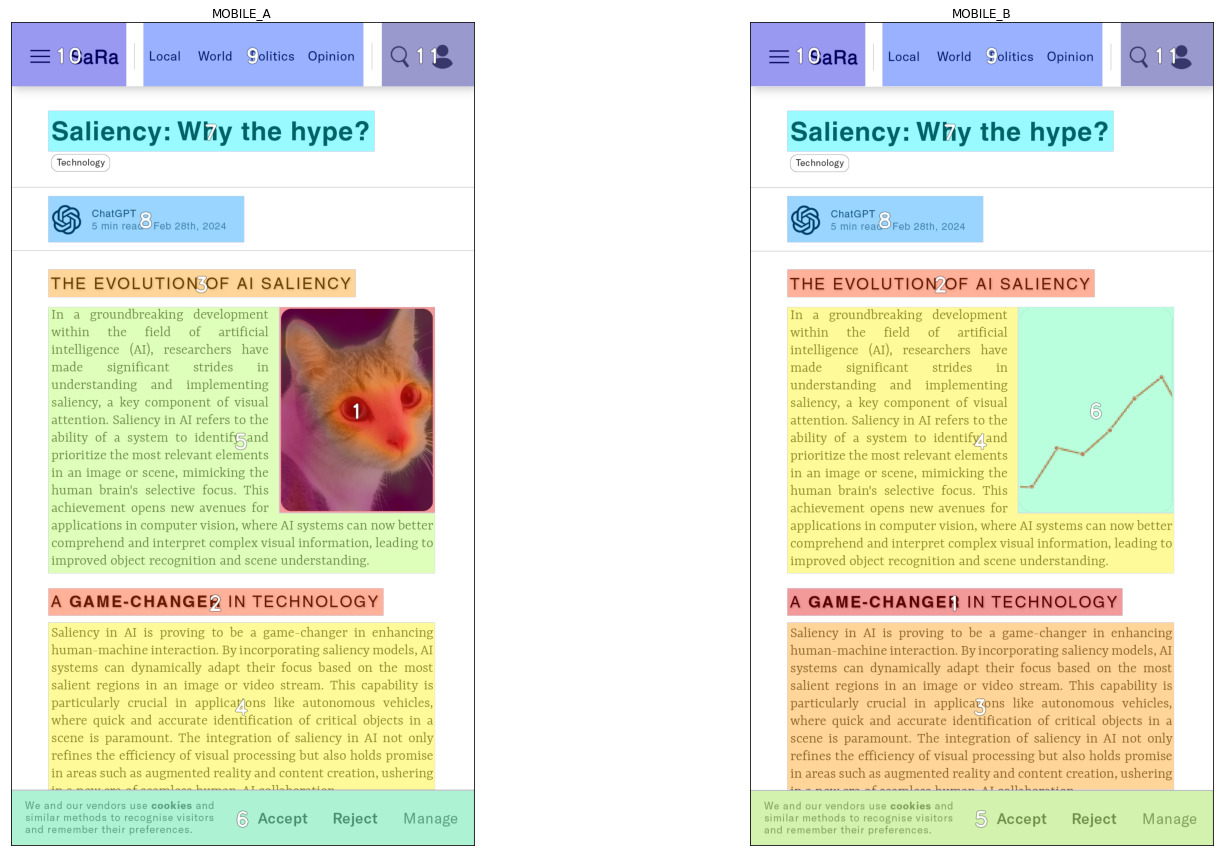

In [10]:
plt.figure(figsize=(24, 12))
plt.subplot(121)
plt.imshow(img_a)
plt.imshow(sara_heatmap_a, alpha=0.4)
plt.imshow(text_overlay_a)
plt.title(name_a)
plt.xticks([])
plt.yticks([])

plt.subplot(122)
plt.imshow(img_b)
plt.imshow(sara_heatmap_b, alpha=0.4)
plt.imshow(text_overlay_b)
plt.title(name_b)
plt.xticks([])
plt.yticks([])

plt.tight_layout()
plt.show()

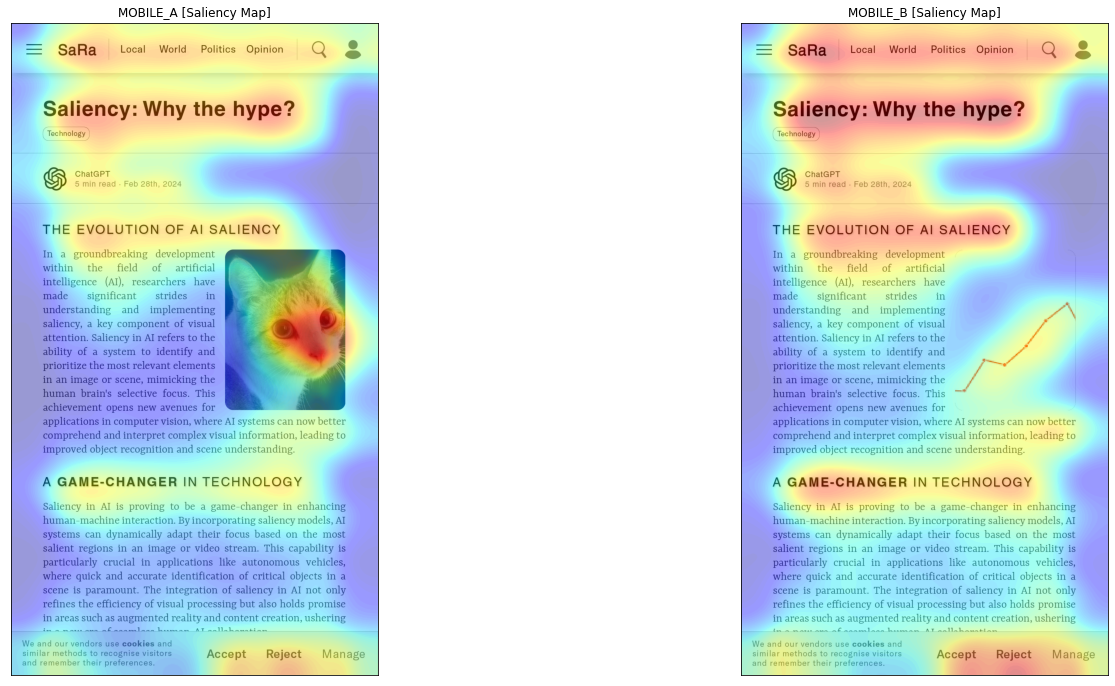

In [11]:
plt.figure(figsize=(24, 12))
plt.subplot(121)
plt.imshow(img_a)
plt.imshow(saliency_map_a, alpha=0.4, cmap='jet')
plt.title(name_a + ' [Saliency Map]')
plt.xticks([]), plt.yticks([])

plt.subplot(122)
plt.imshow(img_b)
plt.imshow(saliency_map_b, alpha=0.4, cmap='jet')
plt.title(name_b + ' [Saliency Map]')
plt.xticks([]), plt.yticks([])

plt.show()

In [12]:
def index_to_coordinates(index, seg_dim, im_size):
    '''
    Given an index and a shape, this function returns the corresponding coordinates.
    '''

    x1 = int((index % seg_dim) * (im_size[1] / seg_dim))
    y1 = int((index // seg_dim) * (im_size[0] / seg_dim))

    x2 = int(x1 + (im_size[1] / seg_dim))
    y2 = int(y1 + (im_size[0] / seg_dim))
    
    return (x1, y1, x2, y2)

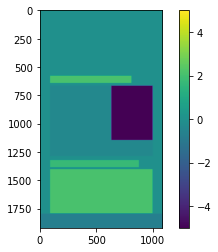

In [15]:
plt.imshow(diff)
plt.colorbar()

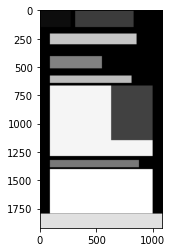

In [105]:
plt.imshow(a_int16, cmap='gray')

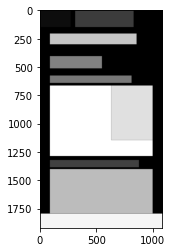

In [104]:
plt.imshow(b_int16, cmap='gray')

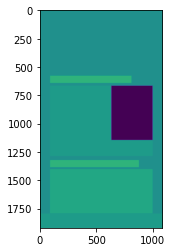

In [107]:
plt.imshow(diff)

In [241]:
ranks_a

[7, 9, 10, 1, 3, 6, 5, 2, 4, 11, 8]

In [257]:
def sara_to_gray(sara_heatmap, sara_list, name):
    sara_heatmap_gray = np.zeros((sara_heatmap.shape[0], sara_heatmap.shape[1]), dtype=np.uint8)

    ranks = []

    done_coords = {}

    for i, _ in enumerate(segments[name]['coordinates']):
        ranks.append(sorted(sara_list)[i][1] + 1)
        x1, y1, x2, y2 = segments[name]['coordinates'][i][1:]

        sara_heatmap_gray = cv2.rectangle(sara_heatmap_gray, (x1, y1), (x2, y2), ranks[i], -1)

        # Check if this will overlap with any previous masks
        for coord in done_coords:
            if x1 < done_coords[coord]['coords'][2] and x2 > done_coords[coord]['coords'][0] and y1 < done_coords[coord]['coords'][3] and y2 > done_coords[coord]['coords'][1]:
                # Check if this is larger than the previous segment
                print('overlap')
                this_size = (x2 - x1) * (y2 - y1)
                previous_size = (done_coords[coord]['coords'][2] - done_coords[coord]['coords'][0]) * (done_coords[coord]['coords'][3] - done_coords[coord]['coords'][1])

                plt.imshow(sara_heatmap_gray)
                plt.show()

                if this_size > previous_size:
                    print('this is larger', i + 1, coord + 1)
                    # Redo the previous segment
                    sara_heatmap_gray = cv2.rectangle(sara_heatmap_gray, (done_coords[coord]['coords'][0], done_coords[coord]['coords'][1]), (done_coords[coord]['coords'][2], done_coords[coord]['coords'][3]), done_coords[coord]['color'], -1)

                    plt.imshow(sara_heatmap_gray)
                    plt.show()

        done_coords[i] = {}
        done_coords[i]['coords'] = (x1, y1, x2, y2)
        done_coords[i]['color'] = ranks[i]

    print(ranks)
    return sara_heatmap_gray.astype(np.int8)

overlap


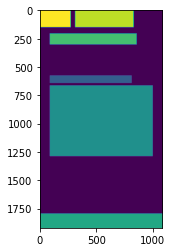

this is larger 7 4


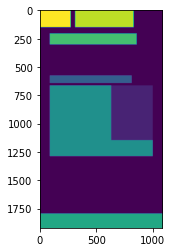

[7, 9, 10, 1, 3, 6, 5, 2, 4, 11, 8]
overlap


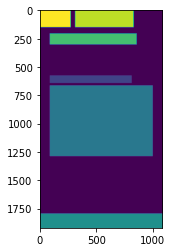

this is larger 7 4


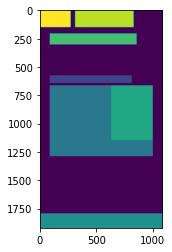

[7, 9, 10, 6, 2, 5, 4, 1, 3, 11, 8]


In [258]:
sara_heatmap_a_gray = sara_to_gray(sara_heatmap_a, sara_list_a, name_a)
sara_heatmap_b_gray = sara_to_gray(sara_heatmap_b, sara_list_b, name_b)

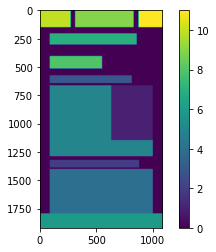

In [259]:
plt.imshow(sara_heatmap_a_gray)
plt.colorbar()

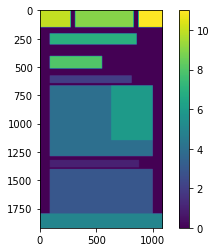

In [260]:
plt.imshow(sara_heatmap_b_gray)
plt.colorbar()

In [261]:
diff = sara_heatmap_a_gray - sara_heatmap_b_gray

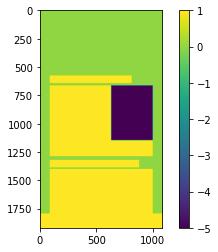

In [263]:
plt.imshow(diff)
plt.colorbar()

/home/matthewkenely/anaconda3/envs/sara/lib/python3.6/site-packages/ipykernel_launcher.py:21: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In future versions, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = copy.copy(mpl.cm.get_cmap("coolwarm"))
/home/matthewkenely/anaconda3/envs/sara/lib/python3.6/site-packages/ipykernel_launcher.py:22: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In future versions, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = copy.copy(mpl.cm.get_cmap("coolwarm"))
/home/matthewkenely/anaconda3/envs/sara/lib/python3.6/site-packages/ipykernel_launcher.py:79: UserWarning: set_ticks() must have been called.


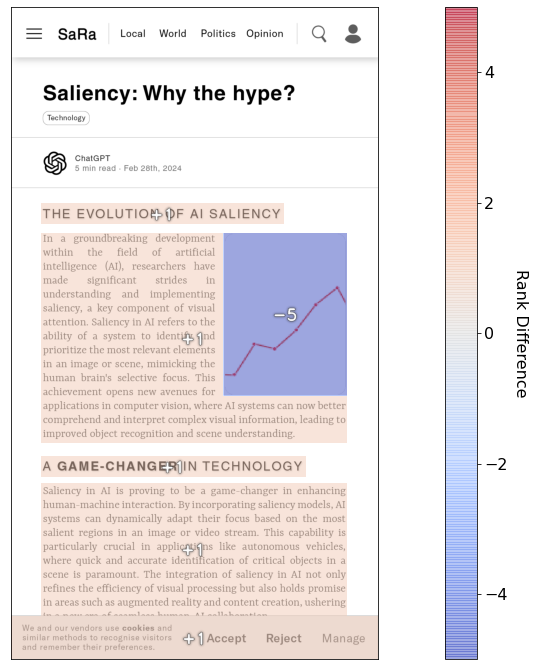

In [265]:
colormap_min = diff.min()
colormap_max = diff.max()
max_abs = max(abs(colormap_min), abs(colormap_max))

# Add a border to the diff image
diff_border = np.ones((diff.shape[0] + 2, diff.shape[1] + 2), dtype=diff.dtype) * max_abs
diff_border[1:-1, 1:-1] = diff
diff = diff_border

diff_qty = [i[1] - j[1] for i, j in zip(sorted(sara_list_a), sorted(sara_list_b))]


# Match the color values in diff to the actual differences in ranks
alpha = np.min(diff_qty)
beta = np.max(np.abs(diff_qty)) 

diff = cv2.normalize(diff, None, alpha=alpha, beta=beta, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_32F)

# Set up colormap with transparency for zero values
cmap = plt.get_cmap('coolwarm')
cmap.set_under('white')  # Set color for values less than vmin to white (fully transparent)
cmap.set_over('white')   # Set color for values greater than vmax to white (fully transparent)

# Show image B
plt.figure(figsize=(24, 12))
plt.imshow(img_b, alpha=1)
diff = cv2.resize(diff, (img_a.shape[1], img_a.shape[0]), interpolation=cv2.INTER_NEAREST)

heatmap = plt.imshow(diff, cmap=cmap, alpha=0.5, vmin=np.min(diff), vmax=np.max(diff))
heatmap.set_array(np.ma.masked_where(diff == 0, diff))  # Mask zero values

# Plot the differences in text top left
diff_text = np.zeros((img_a.shape[0], img_a.shape[1]), dtype=np.uint8)
diff_text = cv2.cvtColor(diff_text, cv2.COLOR_BGR2RGBA)

for i, x1, y1, x2, y2 in segments[name_a]['coordinates']:
    if diff_qty[i-1] != 0:
        # Calculate the center coordinates of the bounding box
        center_x = (x1 + x2) // 2
        center_y = (y1 + y2) // 2

        # Determine the sign of diff_qty[i-1]
        sign = "+" if diff_qty[i-1] >= 0 else ""
        font_size = 1.6
        thickness = 3

        # Create the text to be displayed
        text_to_display = f'{sign}{diff_qty[i-1]}'

        # Get the size of the text
        (text_width, _), _ = cv2.getTextSize(text_to_display, cv2.FONT_HERSHEY_DUPLEX, font_size, thickness)

        # Calculate the position to center the text
        text_position = (center_x - text_width // 2, center_y + 20) 

        # Add the text to the image
        cv2.putText(diff_text, text_to_display, text_position, cv2.FONT_HERSHEY_DUPLEX, font_size, (255, 255, 255), thickness, cv2.LINE_AA)

# Set black regions to transparent
diff_text[diff_text[:, :, 0] < 192] = [0, 0, 0, 0]
diff_text[diff_text[:, :, 0] >= 192, 3] = 255
diff_text = cv2.GaussianBlur(diff_text, (3, 3), 0)
shadow = cv2.GaussianBlur(diff_text, (21, 21), 0)

plt.imshow(shadow, alpha=1)
plt.imshow(diff_text, alpha=1)

plt.xticks([]), plt.yticks([])

# Add a colorbar to the right of the image
cbar = plt.colorbar(heatmap)  # Use the format parameter to control decimal places

# Modify colorbar labels to include a plus sign for positive values
tick_labels = cbar.get_ticks().astype(int)

tick_labels = np.linspace(alpha, beta, 10)

tick_labels_str = [f'{label:+}' if label >= 0 else f'{label:}' for label in tick_labels]
cbar.set_ticklabels(tick_labels_str)
cbar.ax.tick_params(labelsize=16)

# Add cbar title "Rank Difference"
cbar.set_label('Rank Difference', labelpad=20, rotation=270, fontsize=16)

plt.show()
